In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torchvision


from model import FreeFormImageInpaint
from preprocess import get_images, get_mask
from torchsummary import summary
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
n_epochs = 5
alpha = 0.02
learning_rate = 0.001
batch_size = 32

In [5]:
train_loader, val_loader = get_images(batch_size)
image_size = (256, 256)
square_size = 30
binary_mask = get_mask(image_size, square_size)
# reshape binary mask to add batch_size dimension
binary_mask = binary_mask.unsqueeze(0)
binary_mask = binary_mask.expand(batch_size, -1, -1)
binary_mask = binary_mask.to(device)

print(binary_mask.shape)

Files already downloaded and verified


torch.Size([32, 256, 256])


In [6]:
from torchsummary import summary
inpaint = FreeFormImageInpaint(in_channels=4).to(device)
summary(inpaint, [(3, 256, 256), (256, 256)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 256, 256]         --
|    └─GatedConv: 2-1                    [-1, 32, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 256, 256]        3,232
|    |    └─Conv2d: 3-2                  [-1, 32, 256, 256]        3,232
|    |    └─Sigmoid: 3-3                 [-1, 32, 256, 256]        --
|    |    └─LeakyReLU: 3-4               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-5               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-6               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-7               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 256, 256]         --
|    └─GatedConv: 2-1                    [-1, 32, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 256, 256]        3,232
|    |    └─Conv2d: 3-2                  [-1, 32, 256, 256]        3,232
|    |    └─Sigmoid: 3-3                 [-1, 32, 256, 256]        --
|    |    └─LeakyReLU: 3-4               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-5               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-6               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-7               [-1, 32, 256, 256]        --
|    └─GatedConv: 2                      []                        --
|    |   

In [7]:
inpaint = FreeFormImageInpaint(in_channels=4).to(device)
optimizer = torch.optim.Adam(inpaint.parameters(), lr=learning_rate)

In [8]:
len(train_loader)

574

In [9]:
for epoch in range(n_epochs):
    train_loss = 0
    loss = 0
    inpaint.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # model forward
        x_hat = inpaint(data, binary_mask)
        #print("shape of output:", x_hat.shape)
        # compute the loss
        loss = inpaint.loss_function(x_hat, data, binary_mask, alpha)
        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()
        # update running training loss
        train_loss += loss
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.4f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.2294
Epoch: 1 	Training Loss: 0.1060
Epoch: 2 	Training Loss: 0.0947
Epoch: 3 	Training Loss: 0.0788
Epoch: 4 	Training Loss: 0.0699


In [10]:
len(val_loader)

383

In [11]:
val_loss = count = 0
torch.cuda.empty_cache()
inpaint.eval()
input = None
output = None

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(val_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)
        x_hat = inpaint(data, binary_mask)
        loss = inpaint.loss_function(x_hat, data, binary_mask, alpha)
        val_loss += loss
        count += 1

        input = data
        output = x_hat
    
val_loss = val_loss / count
print(f'Validation loss: {val_loss:.4f}')


Validation loss: 0.0626


In [18]:
# B x C x H x W
input = input[:5]
output = output[:5]

# B x H x W x C
input = input.permute(0, 2, 3, 1)
output = output.permute(0, 2, 3, 1)

input = input.cpu()
output = output.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


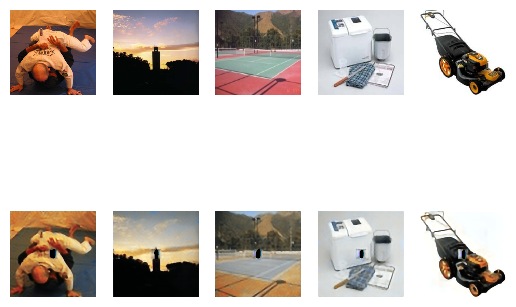

In [19]:
f, axarr = plt.subplots(2,5)
axarr[0, 0].axis("off")
axarr[0, 0].imshow(input[0], interpolation='nearest')
axarr[0, 1].axis("off")
axarr[0, 1].imshow(input[1], interpolation='nearest')
axarr[0, 2].axis("off")
axarr[0, 2].imshow(input[2], interpolation='nearest')
axarr[0, 3].axis("off")
axarr[0, 3].imshow(input[3], interpolation='nearest')
axarr[0, 4].axis("off")
axarr[0, 4].imshow(input[4], interpolation='nearest')

axarr[1, 0].axis("off")
axarr[1, 0].imshow(output[0], interpolation='nearest')
axarr[1, 1].axis("off")
axarr[1, 1].imshow(output[1], interpolation='nearest')
axarr[1, 2].axis("off")
axarr[1, 2].imshow(output[2], interpolation='nearest')
axarr[1, 3].axis("off")
axarr[1, 3].imshow(output[3], interpolation='nearest')
axarr[1, 4].axis("off")
axarr[1, 4].imshow(output[4], interpolation='nearest')